# More with R

**By [Ryan Menezes](https://twitter.com/ryanvmenezes) (Los Angeles Times) & [Christine Zhang](https://twitter.com/christinezhang) (Knight-Mozilla / Los Angeles Times)**

*IRE conference -- New Orleans, LA*  
 
June 18, 2016  

This workshop is a continuation of our previous session, [Getting Started with R](Getting%20started%20with%20R.ipynb)

To recap, in Getting Started with R, we cleaned and merged two census datasets with some demographic information on Louisiana for the years 2000 and 2010, with a view toward understanding population changes pre- and post-Hurricane Katrina, which took place in August 2005.

As in our last session, we will use [The Times-Picayune](http://www.nola.com/politics/index.ssf/2011/02/new_orleans_officials_2010_pop.html) article as the inspiration for our analysis.

** In this session, we will: **

* Use scatterplots and histograms to better see trends in our data
* Query our data for insights we could write about
* Group our data to perform aggregate calculations
* Use R's built-in regression tools to visualize trendlines

** Here are some questions we will set out to answer: **

* How many census tracts in New Orleans had fewer people in 2010 than in 2000?
* Which parishes (Lousiana lingo for counties) saw the most dramatic population changes in that time period?
* How did the occupancy of Louisiana homes change in that time period?
* Which parishes saw the most dramatic occupancy changes?
* Is there a relationship between population and occupancy rate?

The following code and annotations were written in a Jupyter notebook. The code is best run in RStudio version 0.99.902 using R version 3.3.0

Let's read in the census data file we created in our last workshop and visually inspect the first six rows using `head`.

In [1]:
census <- read.csv('census_comparison.csv')
head(census)

,fips.code,tract,parish,state,population.00,total.housing.units.00,occupied.housing.units.00,vacant.housing.units.00,population.10,total.housing.units.10,occupied.housing.units.10,vacant.housing.units.10
1,22001960100,Census Tract 9601,Acadia Parish,Louisiana,6188,2410,2236,174,6213,2574,2345,229
2,22001960200,Census Tract 9602,Acadia Parish,Louisiana,5056,1909,1764,145,5988,2362,2144,218
3,22001960300,Census Tract 9603,Acadia Parish,Louisiana,3149,1246,1145,101,3582,1427,1286,141
4,22001960400,Census Tract 9604,Acadia Parish,Louisiana,5617,2176,1991,185,6584,2604,2362,242
5,22001960500,Census Tract 9605,Acadia Parish,Louisiana,4927,1796,1692,104,6093,2349,2178,171
6,22001960600,Census Tract 9606,Acadia Parish,Louisiana,5654,2292,2073,219,5972,2504,2306,198


### Grouping and summing populations by parish

Recall that our information is organized by census tract. We'll use dplyr's `group_by` to group the data by parish. We'll use dplyr's `summarise_each` to add up the columns. 

Then we'll calculate the percent change between the two years:

In [2]:
## if dplyr was not installed we would have to run this
# install.packages('dplyr')

## to import the package and all of its functions 
library('dplyr')

Warning message:
: package ‘dplyr’ was built under R version 3.2.4
Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [3]:
parishes <- census %>% # notice the use of "%>%"
group_by(parish) %>%  # this tells R to group our data by parishes
summarise_each( 
    # sum all the columns 
    funs(sum(., na.rm = TRUE)),
    # except the non-numerical ones
    -fips.code, -tract, -state
) 

You'll notice that we used a strange symbol, `%>%`, to accomplish this. This is what R calls the "pipe operator." It has gained popularity in recent years as an alternative to nesting functions. 

If we were to accomplish the same task without piping, we would need to write the following unwieldy line of code:

```
summarise_each(group_by(census, parish), funs(sum(., na.rm = TRUE)), -fips.code, -tract, -state)
```

In [4]:
parishes$perc.pop.diff <- (parishes$population.10 - parishes$population.00) / parishes$population.00 * 100

head(parishes)

,parish,population.00,total.housing.units.00,occupied.housing.units.00,vacant.housing.units.00,population.10,total.housing.units.10,occupied.housing.units.10,vacant.housing.units.10,perc.pop.diff
1,Acadia Parish,58861,23209,21142,2067,61773,25387,22841,2546,4.947249
2,Allen Parish,25440,9157,8102,1055,25764,9733,8516,1217,1.273585
3,Ascension Parish,76627,29172,26691,2481,107215,40784,37790,2994,39.91804
4,Assumption Parish,23388,9635,8239,1396,23421,10351,8736,1615,0.141098
5,Avoyelles Parish,41481,16576,14736,1840,42073,18042,15432,2610,1.427159
6,Beauregard Parish,32986,14501,12104,2397,35654,15040,13159,1881,8.08828


Now we can answer the question: **Which parishes (Lousiana lingo for counties) saw the most dramatic population changes?**

We'll do this by arranging the columns by the percent change in population, using dplyr's `arrange`. To make the output easier to see, we'll only select a few of the columns.

In [5]:
parishes %>% 
select(parish, population.00, population.10, perc.pop.diff) %>% # select the columns of interest
arrange(perc.pop.diff) %>%
head()

,parish,population.00,population.10,perc.pop.diff
1,St. Bernard Parish,67229,35897,-46.60489
2,Cameron Parish,9991,6839,-31.54839
3,Orleans Parish,484674,343829,-29.05974
4,Tensas Parish,6618,5252,-20.64068
5,East Carroll Parish,9421,7759,-17.64144
6,Plaquemines Parish,26757,23042,-13.88422


The results of a query like this one could turn into a paragraph in a story. The Times-Picayune did just this with the following sentence:

> Hard-hit St. Bernard saw the most dramatic population decline, losing 47 percent of its population compared with 2000. Plaquemines Parish's population also fell, though only by 14 percent.


For now, we'll focus on just New Orleans, or the Orleans Parish. To help us filter the data set to only include the census tracts in this parish, we are going to import a package called dplyr.

We'll filter the data and run the `str` command, which gives you the structure of the variable as defined by R:

In [6]:
orleans <- census %>% filter(parish == 'Orleans Parish')
orleans %>% str() # this is equivalent to str(orleans)

'data.frame':	211 obs. of  12 variables:
 $ fips.code                : num  2.21e+10 2.21e+10 2.21e+10 2.21e+10 2.21e+10 ...
 $ tract                    : Factor w/ 793 levels "Census Tract 1",..: 1 159 368 453 596 597 598 599 600 601 ...
 $ parish                   : Factor w/ 64 levels "Acadia Parish",..: 36 36 36 36 36 36 36 36 36 36 ...
 $ state                    : Factor w/ 1 level "Louisiana": 1 1 1 1 1 1 1 1 1 1 ...
 $ population.00            : int  2381 1347 1468 2564 2034 2957 2342 5131 2902 4400 ...
 $ total.housing.units.00   : int  1408 691 719 1034 704 1106 978 2100 992 1641 ...
 $ occupied.housing.units.00: int  1145 496 559 873 506 1011 671 1886 893 1593 ...
 $ vacant.housing.units.00  : int  263 195 160 161 198 95 307 214 99 48 ...
 $ population.10            : int  2455 1197 1231 2328 849 2534 1605 3925 2205 4346 ...
 $ total.housing.units.10   : int  1513 738 641 1137 328 1108 922 1795 994 1644 ...
 $ occupied.housing.units.10: int  1229 496 467 911 269 923 498 1456

### Scatterplots

Plotting our data can reveal some interesting trends about the New Orleans population in 2000 and its population in 2010. R has a `plot` function where we can specify the x and y variables we want to plot:

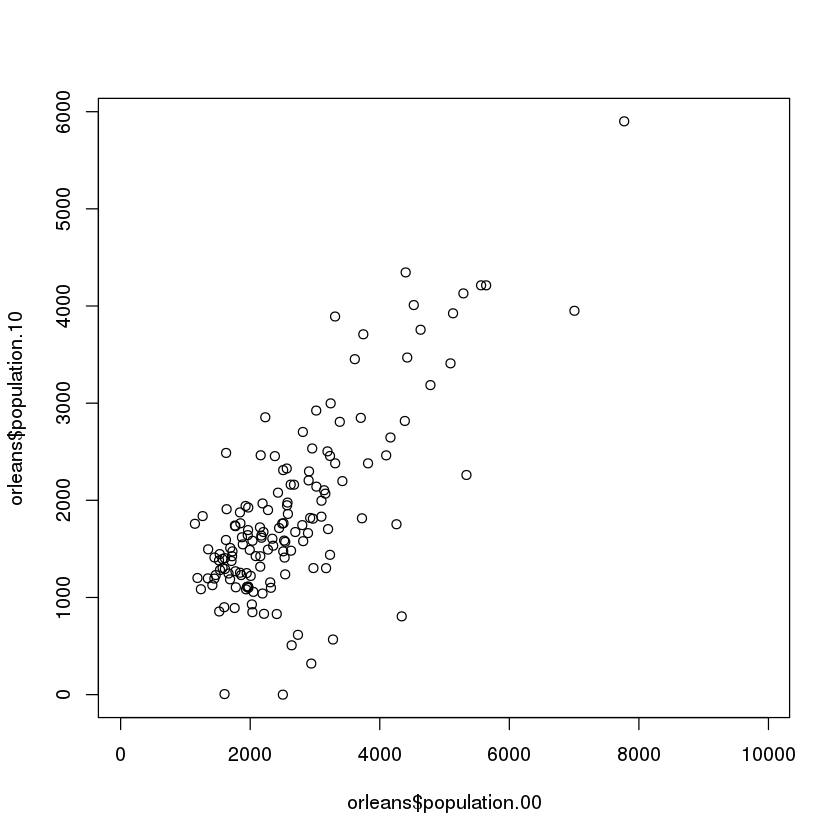

In [7]:
plot(orleans$population.00, orleans$population.10)

This doesn't tell us very much, other than the (intuitive) fact that census tracts with higher populations in 2000 also tended to have higher populations in 2010. 

We can better examine the relationship if we draw a 45-degree line with `abline(0, 1)`. If a census tract's population in 2010 was exactly the same as its population in 2000, it would fall on this line. If its 2010 population was lower than its 2000 population, it would fall below this line.

This gives us a quick way to visually inspect the changes in population.

While we're at it, we'll add some x and y limits, labels and a title.

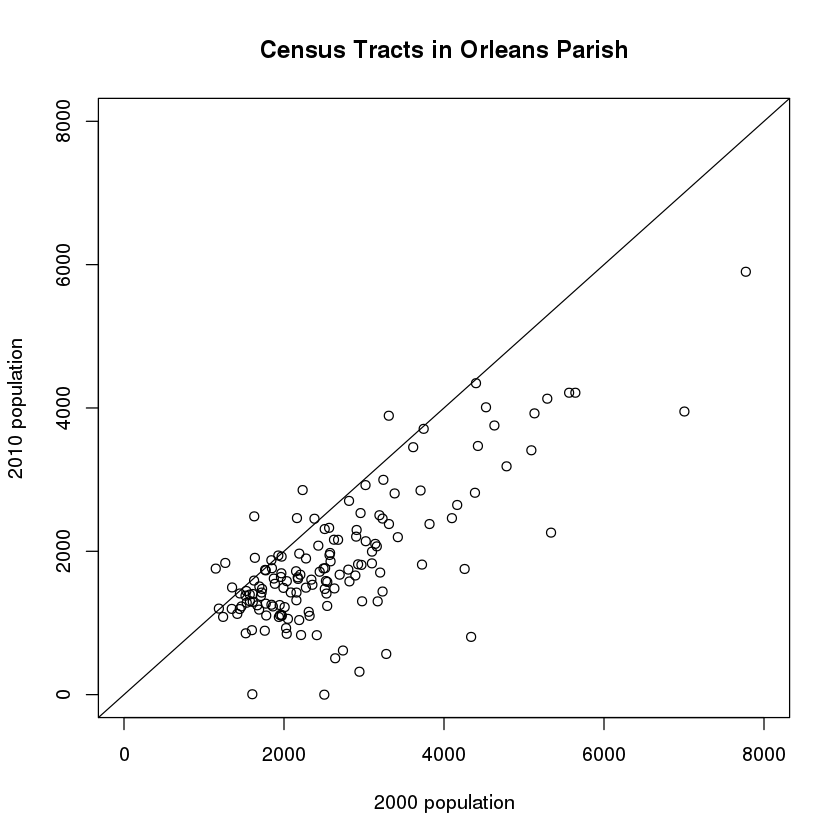

In [8]:
plot(
    orleans$population.00,
    orleans$population.10, 
    xlim = c(0, 8000), 
    ylim = c(0, 8000),
    xlab = '2000 population',
    ylab = '2010 population',
    main = 'Census Tracts in Orleans Parish'
)

abline(0, 1) # Draw a line with y-intercept of 0 and slope of 1

Most of the points fall below the line, indicating most census tracts saw population drops. This makes sense with our previous finding that New Orleans overall saw a 29% drop in population between 2000 and 2010.

We can further quantify this by answering the question: **How many census tracts in New Orleans had fewer people in 2010 than in 2000?**

In [9]:
orleans$pop.diff <- orleans$population.10 - orleans$population.00

After calculating the difference, we now need to run a query that asks a programming equivalent version of the question above: "How many numbers in the pop.diff column are less than 0?"

In [10]:
pop.drops.orleans <- sum(orleans$pop.diff < 0, na.rm = TRUE)

In [11]:
print(paste('In New Orleans,', pop.drops.orleans, 'tracts had fewer people in 2010 than in 2000.'))

[1] "In New Orleans, 135 tracts had fewer people in 2010 than in 2000."


### Changes in Louisiana housing occupancy

We can calculate the occupancy rate (or the percent of housing units that are occupied) for both years and the percentage point change, and write all of these variables to new columns in our data frame:

In [12]:
parishes$perc.occupied.00 <- parishes$occupied.housing.units.00 / parishes$total.housing.units.00 * 100
parishes$perc.occupied.10 <- parishes$occupied.housing.units.10 / parishes$total.housing.units.10 * 100
parishes$perc.occupied.diff <- parishes$perc.occupied.10 - parishes$perc.occupied.00

We can now answer the question, **Which parishes saw the most dramatic occupancy changes?** 

All we have to do is arrange the data by `perc.occupied.diff`, our new variable for the percentage point change in occupancy rates.

Note that this time, we'll arrange the data using `arrange(desc(perc.occupied.diff))` to first see the most dramatic increases in occupancy rates - parishes where occupancy rates went up the most. `arrange`'s default is to arrange in ascending order.

In [13]:
parish.occupancy.rates <- parishes %>% 
select(parish, perc.occupied.00, perc.occupied.10, perc.occupied.diff) %>% 
arrange(desc(perc.occupied.diff)) # arrange(desc()) arranges in descending order

We can use `head` to show the first few rows of the data. We specify n = 3 to show the first 3 rows.

In [14]:
head(parish.occupancy.rates, n = 3)

,parish,perc.occupied.00,perc.occupied.10,perc.occupied.diff
1,St. Helena Parish,76.93683,84.13592,7.199093
2,Cameron Parish,67.31634,71.66713,4.350789
3,Beauregard Parish,83.47011,87.49335,4.023246


It might be more interesting for us to see parishes where the occupancy rates went *down* the most.  

We can see this using the `tail` command, which shows us the last few rows of the data. 

In [15]:
tail(parish.occupancy.rates, n = 3)

,parish,perc.occupied.00,perc.occupied.10,perc.occupied.diff
1,Tensas Parish,71.92617,64.70063,-7.225543
2,Orleans Parish,87.52156,74.86098,-12.66058
3,St. Bernard Parish,93.77753,78.72454,-15.05298


### Histograms

Maybe we want to know more about the overall trends in parishes' occupancy rates. For example, did most Louisiana parishes see decreases or increases in occupancy? 

We can explore this question using a histogram of perc.occupied.diff. A histogram is a good plot for understanding the distribution of a variable. On the x-axis, it plots the range of values of perc.occupied.diff (the change in occupancy over the two years) and on the y-axis, it plots how frequently these values occurred in our data.

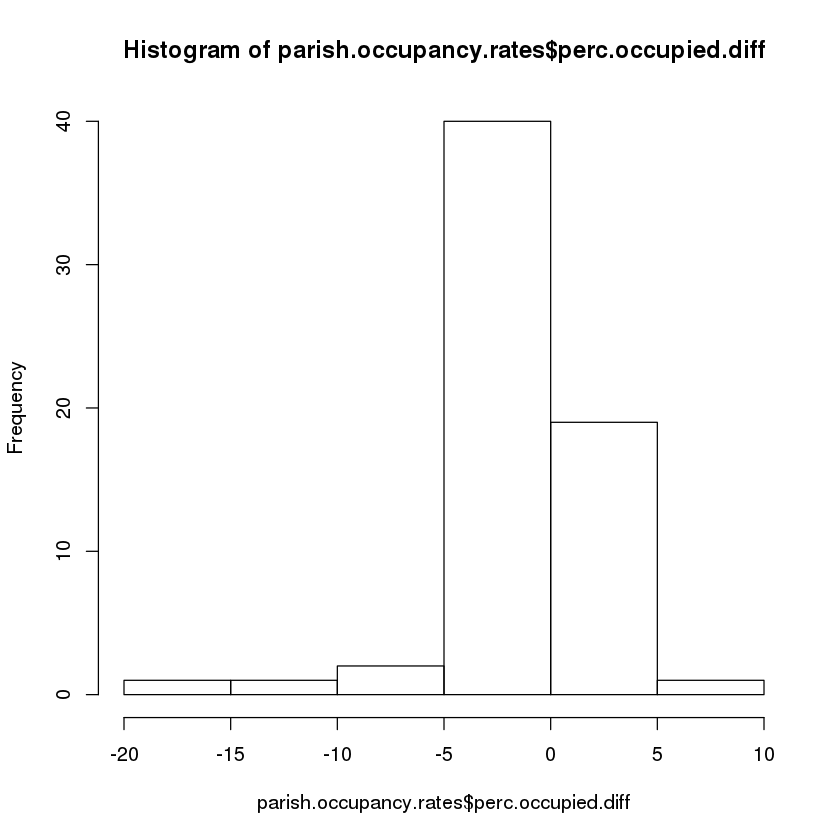

In [16]:
hist(parish.occupancy.rates$perc.occupied.diff)

As we did above, let's improve on this default plot that R spit out.

The histogram grouped `perc.occupied.diff` by bins, which are equal-sized intervals of the variable's values. Here we have six bins, but we would understand the distribution in greater detail if we had more bins. To do this, we need to add an argument called `breaks`. 

Let's also draw a vertical line at 0 to quickly see how many parishes saw drops in occupancy rates. We'll also add some labels.

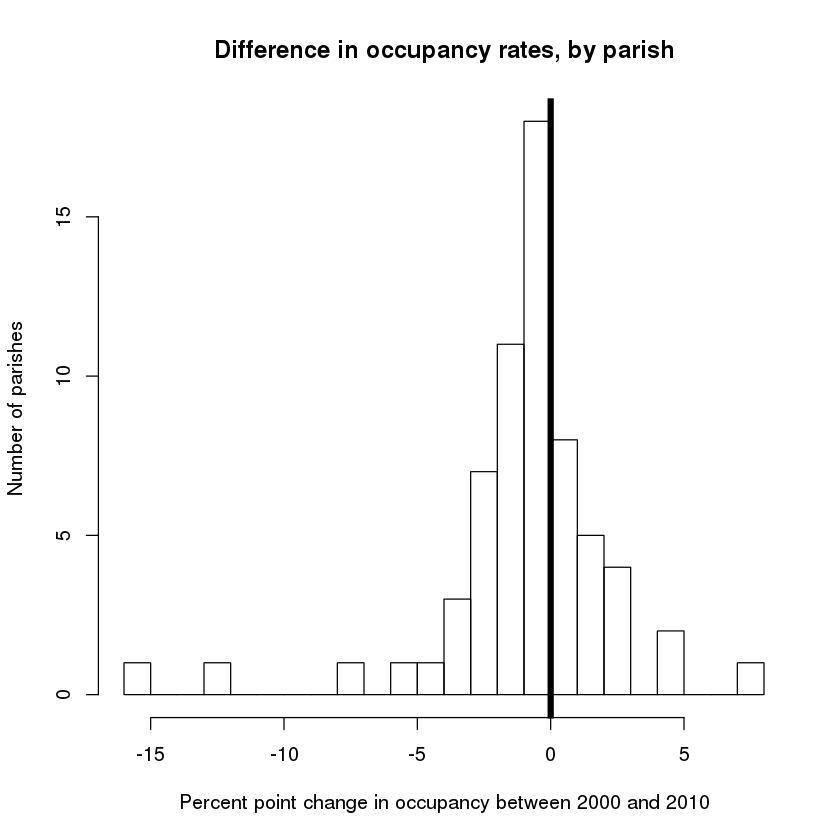

In [17]:
hist(
    parish.occupancy.rates$perc.occupied.diff, 
    breaks = 20, 
    main = 'Difference in occupancy rates, by parish',
    xlab = 'Percent point change in occupancy between 2000 and 2010', 
    ylab = 'Number of parishes'
)
abline(v = 0, lwd = 5) # draw a vertical line at 0 with width of 5 pixels

Now we can see that most of the parishes' occupancy rates went down.

### Relationships and trend lines

Let's examine the relationship between two of the variables in our data frame. We can run the `names` command to find the names of our columns. 

In [18]:
names(parishes)

[1] "parish"                    "population.00"            
 [3] "total.housing.units.00"    "occupied.housing.units.00"
 [5] "vacant.housing.units.00"   "population.10"            
 [7] "total.housing.units.10"    "occupied.housing.units.10"
 [9] "vacant.housing.units.10"   "perc.pop.diff"            
[11] "perc.occupied.00"          "perc.occupied.10"         
[13] "perc.occupied.diff"

We'll use population.10 (the 2010 population) and perc.occupied.10 (the 2010 occupancy rate). 

We can draw the straight line that best fits the relationship between these two variables. In order to do this, we can use `abline`, but with an additional argument, `lm`, which stands for "linear model." We have to tell R that `parishes$perc.occupied.10` is our y-variable and `parishes$population.10` is our x variable, this time in a slightly different format than the plot. 

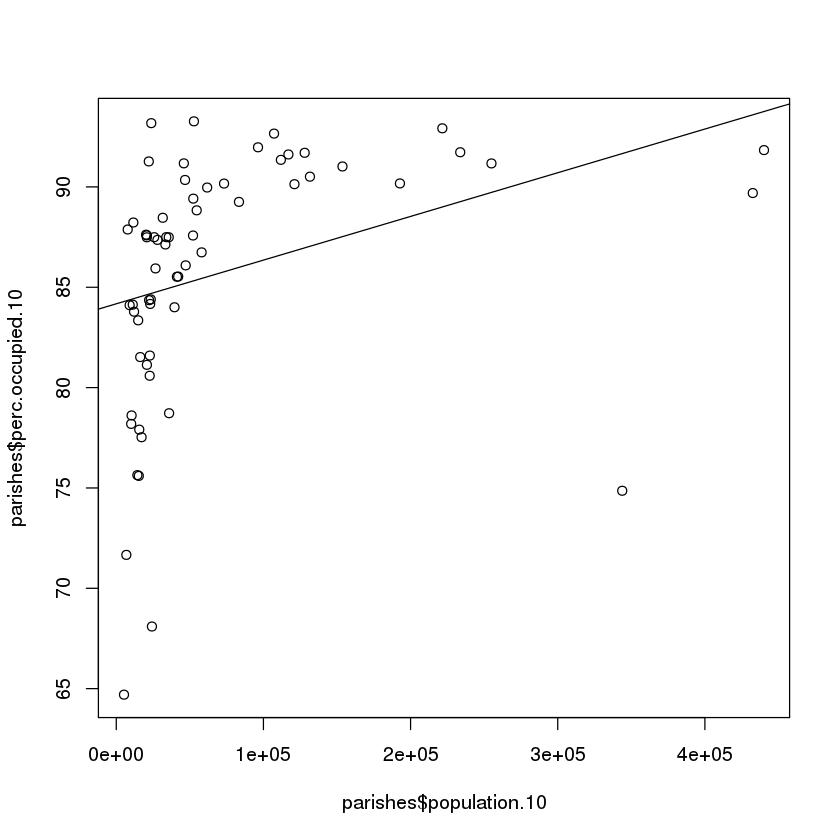

In [19]:
plot(parishes$population.10, parishes$perc.occupied.10)
abline(lm(parishes$perc.occupied.10 ~ parishes$population.10))

We can see from the plot that a straight line does not fit the data well. For one, the straight line would cross 100 percent, which is impossible. A better fit for this relationship would be a curved line.

To fit a curve, we have to do a square-root transformation of the 2010 population, then make that the x-variable in our model. A square-root transformation is a statistical concept that you can read more about [here](https://infoactive.co/data-design/ch11.html).

In [20]:
curved.model <- lm(parishes$perc.occupied.10 ~ log(parishes$population.10))

Plotting the curve is slightly more complicated. For each x-value, we want to plot the predicted y-value. In R, we have to first sort the data points of the curve. The `lines` function will then connect all of the points.

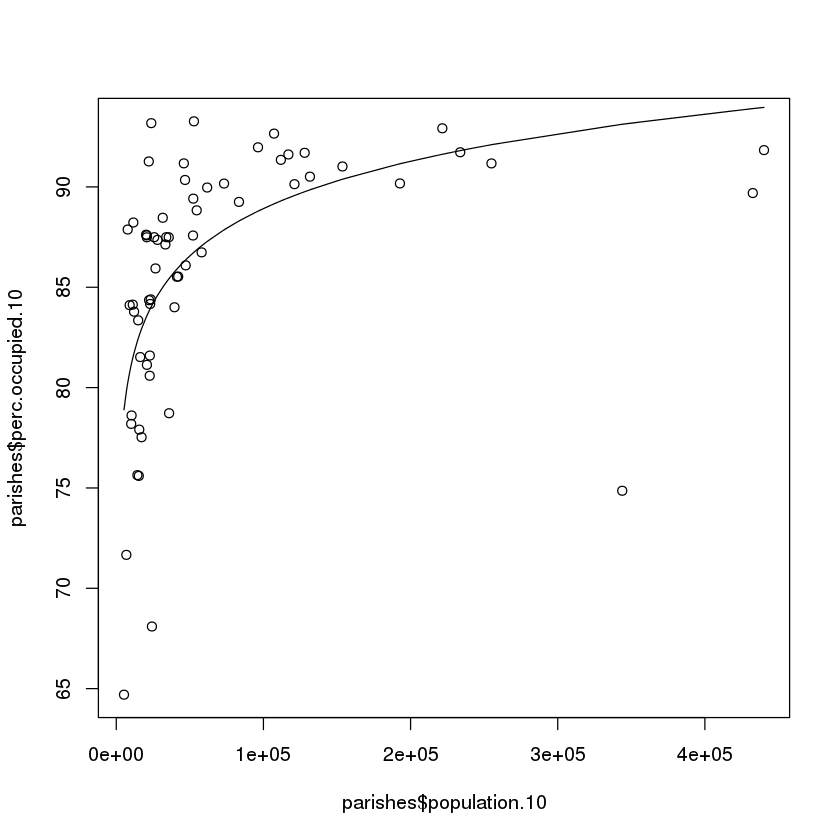

In [21]:
predicted.values <- predict(curved.model)

plot(parishes$population.10, parishes$perc.occupied.10)
lines(sort(parishes$population.10), sort(predicted.values))

The curve appears to fit the data better than the line. For example, the linear trend was bad at estimating the relationship between population and occupancy rate for parishes with very low populations.

What's most interesting about this plot is the presence of a large outlier. Let's finalize a better version of this plot by adding text labels for each parish so we can identify which parish has a high population but a very low occupancy rate.

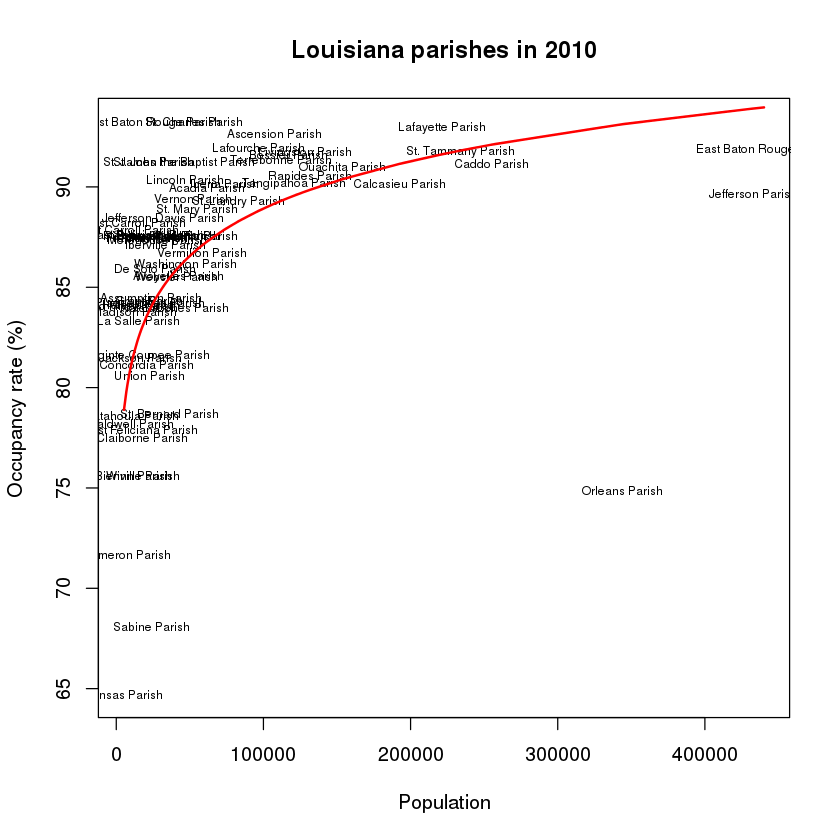

In [22]:
options(scipen=5) # to prevent axes from appearing in scientific notation
plot(
    parishes$population.10, parishes$perc.occupied.10, type = "n", # type = "n" tells R not to plot the points
    xlab = "Population",
    ylab = "Occupancy rate (%)",
    main = "Louisiana parishes in 2010"
)
text(parishes$population.10, parishes$perc.occupied.10, labels = parishes$parish, cex = 0.6) # adding text where the points should be
lines(sort(parishes$population.10), sort(predicted.values), col = "red", lwd = 2)

This concludes our workshop, More with R. We hope you found it useful!


Any questions?

* christine.zhang@latimes.com or [@christinezhang](https://twitter.com/christinezhang) on Twitter
* ryan.menezes@latimes.com or [@ryanvmenezes](https://twitter.com/ryanvmenezes) on Twitter